### Image recognition --- CIFAR-10

In [1]:
# download dataset
from torchvision import datasets

data_path = './data/' # the location which the data will be downloaded
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
img, label = cifar10_train[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FCC08BFE7D0>, 1, 'car')

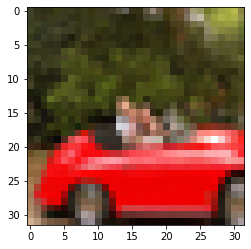

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

In [4]:
# transform img to tensor, label doesn't change
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape # 3 channels, 32 height, 32 width

torch.Size([3, 32, 32])

In [5]:
# transform imgs to tensor at the dataset step
cifar10_train = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.ToTensor()
)
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.ToTensor()
)

# check the type and dimension
img_t, _ = cifar10_train[99]
print(img_t.shape, img_t.dtype) # shape and dtype are not objects

torch.Size([3, 32, 32]) torch.float32


In [6]:
# what does transform do?
print(img_t.min(), img_t.max())
# turns data into 32-bit floating-point 
# scales the values down from 0.0 to 1.0
# changes from H W C to C H W

tensor(0.) tensor(1.)


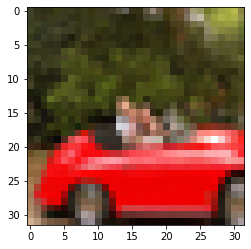

In [7]:
# whether it gets the same img
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [8]:
# normalization
import torch as t

# first calculate mean among all the images at each channel
# stack all the imgs to one tensor
# dim=3: stack along an extra dimension (CHW:0, 1, 2 dimension)
imgs = t.stack([img_t for img_t, _ in cifar10_train], dim=3)
imgs_v = t.stack([img_t for img_t, _ in cifar10_val], dim=3)
print(imgs.shape)

# compute the mean along each channel
# view keeps the 3 channel, and merges all the remaining dimensions into one
mean_imgs = imgs.view(3, -1).mean(dim=1)
std_imgs = imgs.view(3, -1).std(dim=1)

mean_imgs_v = imgs_v.view(3, -1).mean(dim=1)
std_imgs_v = imgs_v.view(3, -1).std(dim=1)

# concatenate it after transform
cifar10_train = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean_imgs, std_imgs)
    ])   
)

cifar10_test = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean_imgs_v, std_imgs_v)
    ])
)

torch.Size([3, 32, 32, 50000])


In [9]:
print(mean_imgs, std_imgs)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


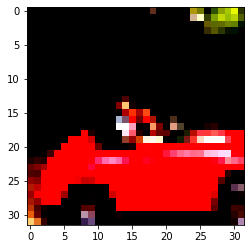

In [10]:
# plot normalized img
img_t, _ = cifar10_train[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

### Tell bird and plane apart

In [11]:
# subclass of datasets only containing bird and plane
# label: plane--0, bird--2
label_map = {0: 0, 2: 1}
label_name = ['plane', 'bird']

cifar10_birdplane_train = [(img, label_map[label])
                           for img, label in cifar10_train
                           if label in label_map]
cifar10_birdplane_test = [(img, label_map[label])
                          for img, label in cifar10_test
                          if label in label_map]

In [12]:
import torch.nn as nn

# softmax: change each value into classification probability
x = t.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])
# dim =0 means count row(0) along each column
# dim=1 means count column(1) along each row
softmax = nn.Softmax(dim=1)
print(softmax(x))

_, pa = t.max(softmax(x), dim=1)
_

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])


tensor([0.6652, 0.6652])

In [13]:
from collections import OrderedDict

# strech each img into a tensor with 3*32*32=3072 features 
img1, label1 = cifar10_birdplane_train[1]
img_tensor = img1.view(-1).unsqueeze(0)

model = nn.Sequential(OrderedDict([
    ('hidden linear', nn.Linear(3072, 520)),
    ('hidden activate', nn.Tanh()),
    ('output linear', nn.Linear(520, 2)),
    ('softmax', nn.LogSoftmax(dim=1)) # log probability for NLL loss.
]))

loss = nn.NLLLoss()

output = model(img_tensor)

# t.tensor([label1]) = tensor([1]), it can be converted with 
# one-hot encoding to [0, 1]
loss(output, t.tensor([label1])) 

tensor(0.4512, grad_fn=<NllLossBackward>)

In [16]:
# work flow
from torch import optim

# load data into minibatches
train_loader = t.utils.data.DataLoader(cifar10_birdplane_train,
                                      batch_size=64,
                                      shuffle=True) # shuffle at the start of each epoch

n_epoches = 10
optimizer = optim.SGD(model.parameters(), lr=1e-2)

for epoch in range(1, n_epoches+1):
    for imgs, labels in train_loader:
        batch = imgs.shape[0] # sometimes the batch size would not be 64
        outputs = model(imgs.view(batch, -1))
        loss_value = loss(outputs, labels)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print('epoch %d, loss %f'%(epoch, float(loss_value)))
    
# validation
test_loader = t.utils.data.DataLoader(cifar10_birdplane_test,
                                     batch_size=64,
                                     shuffle=True)

total = 0
correct = 0

with t.no_grad():# don't compute gradient
    for imgs, labels in test_loader:
        batch = imgs.shape[0]
        outputs = model(imgs.view(batch, -1))
        _, predicted = t.max(outputs, dim=1) # predicted is the predicted label
        total += labels.shape[0]
        # tensor could do this. == will compare each value in the tensor.
        correct += int((predicted == labels).sum()) 
        
    print('accuracy %f' % (correct/total))

epoch 10, loss 0.016736
accuracy 0.816500


### Using convolution kernel

In [95]:
# create convolution kernel
# 3: input channel, 16: output channel
# kernel_size=3 == kernel_size = (3,3)
conv_2d = nn.Conv2d(3, 16, kernel_size=3, padding=1)
print(conv_2d, '\n', conv_2d.weight.shape, '\n', conv_2d.bias.shape)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
 torch.Size([16, 3, 3, 3]) 
 torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 32, 32])


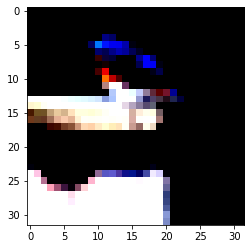

<function matplotlib.pyplot.show(*args, **kw)>

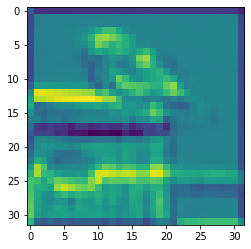

In [96]:
# using kernel on img
img, _ = cifar10_birdplane_train[1]

# add one dimension to indicate batch size=1 using unsqueeze(0)
con_img = conv_2d(img.unsqueeze(0))
print(img.unsqueeze(0).shape, con_img.shape)

# img[0] means to just get the first channel, and convert it into np.array
plt.imshow(img.permute(1, 2, 0))
plt.show()
# con_img[0,0] mneans to just get one batch and one channel
plt.imshow(con_img[0, 0].detach())
plt.show

In [97]:
# we could decide the value of weights and bias by ourself
with t.no_grad():
    conv_2d.bias.zero_()
# with t.no_grad():
    conv_2d.weight.fill_(1.0/9.0) # mean kernel

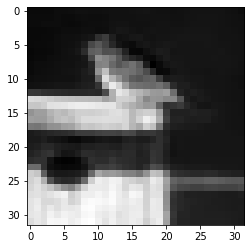

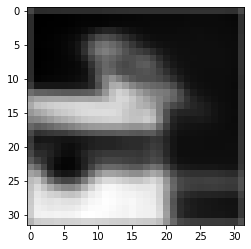

In [104]:
con_img = conv_2d(img.unsqueeze(0))

plt.imshow(img[0].detach(), cmap='gray')
plt.show()
# mean kernel generates a blurred img
plt.imshow(con_img[0,0].detach(), cmap='gray')
plt.show()